In [1]:
# * to import all modules 
from fastai.vision import *

from fastai.metrics import accuracy
import torch
import torch.nn as nn
from fastai.callbacks.hooks import *
from torchvision import transforms

In [2]:
# directory structure in path has to very specific - 2 folders train and valid which are compulsory
# can also have test
# each folder has to have sub folders with the classes named for the classes
path = '/project/sds-capstone-aaai/met/sana/data_23_classes/'

In [3]:
# List transformations 
tfms = get_transforms(do_flip=True)

In [4]:
# data loader
# data = (ImageList.from_folder(path)
#         .split_by_folder()          
#         .label_from_folder()
#         .transform(tfms, size=32)
#         .databunch()
#         .normalize(imagenet_stats))

# alternate code for data loader for fastai
# when we give it the folder 'data' it picks train and valid
# all syntax below - ImageList or ImageDataBunch to make the data loader
# defines the size of the images also - auto resizes them to 256x256, can put any value
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=256)
data.normalize(imagenet_stats)

# results below show train n=87298 valid n=9711 

ImageDataBunch;

Train: LabelList (87298 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
books,books,books,books,books
Path: /project/sds-capstone-aaai/met/sana/data_23_classes;

Valid: LabelList (9711 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
books,books,books,books,books
Path: /project/sds-capstone-aaai/met/sana/data_23_classes;

Test: None

In [5]:
# training
# ResNet-50 is SOTA generally used for many image-related tasks like image classification and object detection
# only initializing the model for Resnet 50 using the data loader before
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [6]:
# to visualize what the model is, this is the standard resnet 50 with changes to the last 7 layers
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [7]:
# to unfreeze prior layers so that the model trains on all layers
# if we do not do learn.unfreeze will only learn off the last layer
learn.unfreeze()

In [8]:
#for learning rate (ie how much you change the weight of the model at every step when the gradients are calculated towards
# global minima)
# we say global minima but what we mean is that each weight has to get to its minimum loss
# https://towardsdatascience.com/10-new-things-i-learnt-from-fast-ai-v3-4d79c1f07e33 see 3
learn.lr_find() 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


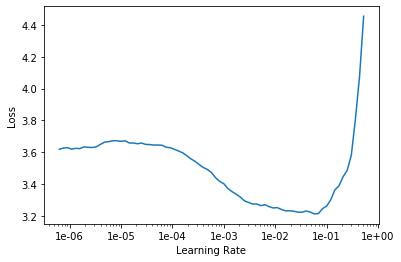

In [9]:
# ideal learning rate on this graph when the slope is steepest ie between 10^-4 and 10^-3
# we pick a learning rate where the loss is decreasing the most
# this is a fastai specific plot
# generally 10^-3 is a good value to pick
learn.recorder.plot()

In [9]:
# this is to implement differential learning ie LESS from the initial layers and MORE from the later ones
# because the later layers pick more complex representations of the data
# we should ideally stop the training when the valid_loss is lower than the train_loss
# 5 stands for how many epochs
learn.fit_one_cycle(5, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.786193,1.799132,0.435383,36:19
1,1.675717,1.784404,0.473587,36:13
2,1.470507,1.399960,0.552363,36:17
3,1.353713,1.280615,0.578519,36:11
4,1.256867,1.248615,0.587890,36:11


In [10]:
# saves the current model
# edit the number of epochs and see where the valid_loss gets closer to the train_loss
# want to pick an epoch where ideally we are not overfitting the model
learn.save('5_epochs_diff_lr')

In [11]:
# to run the model above on the validation dataset since we have now trained it
# ClassificationInterpretation is a class which saves in interp all the losses and important metrics
# for each image in the validation
interp = ClassificationInterpretation.from_learner(learn)

# to get the losses and the indexes of the images
losses,idxs = interp.top_losses()

# check to see if all went OK 
len(data.valid_ds)==len(losses)==len(idxs)

True

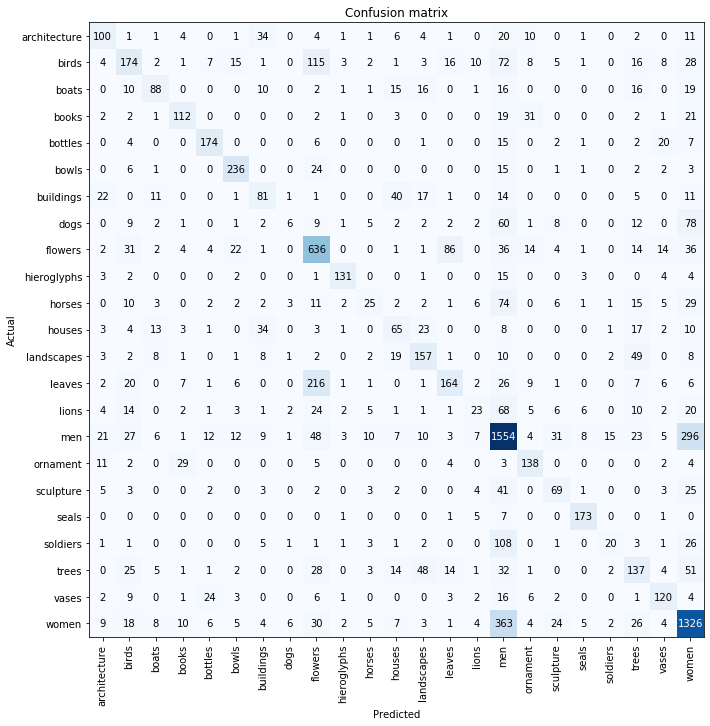

In [20]:
# use values in the interp variable to plot the % for the confusion matrix
# no threshold for the probabilities, uses the highest probability (total of 1) for any class to say thats what it is
interp.plot_confusion_matrix(figsize=(10,10))

9617 misclassified samples over 9711 samples in the validation set.


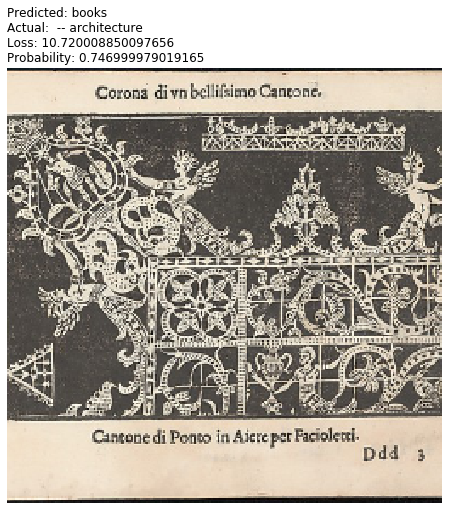

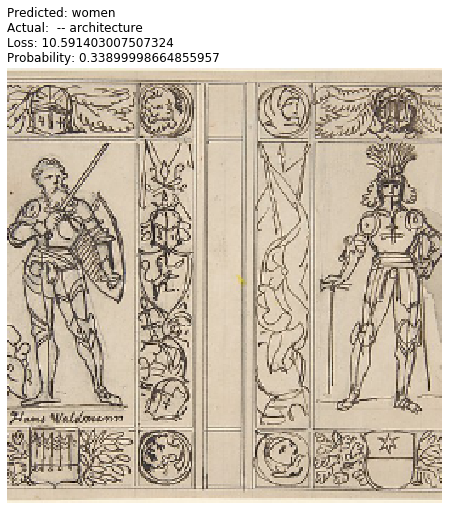

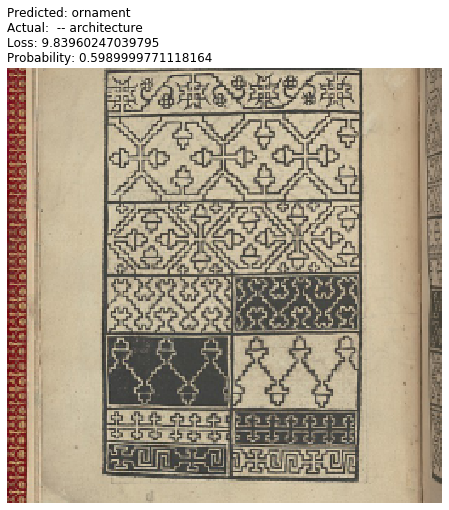

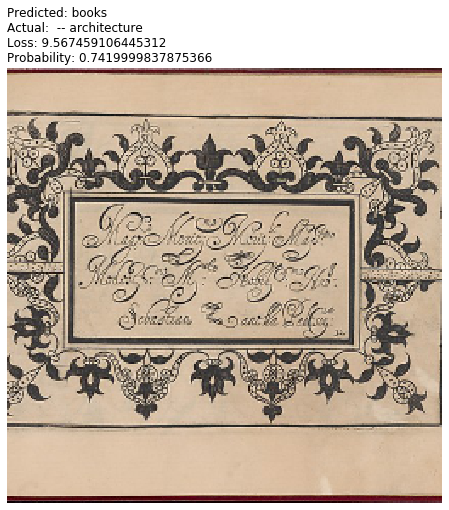

In [13]:
# this is to plot 4 misclassified can change to eg all (but will take LONG)
# plots out images in descending order (highest loss = misclassified)
interp.plot_multi_top_losses(4)

In [14]:
# Saving all the predictions for every image in the preds variable
preds = interp.preds.detach().cpu().numpy()
# Saving details (name and class) of all the validation images in the variable row
valid_details = interp.ds.to_df()


def show_heatmap(interp, index, label='', save=False, savepath=False):
    # takes the prediction value and rounds off to 4 decimal points
    pred_architecture = round(preds[index][0], 4)
    pred_birds = round(preds[index][1], 4)
    pred_boats = round(preds[index][2], 4)
    pred_books = round(preds[index][3], 4)
    pred_bottles = round(preds[index][4], 4)
    pred_bowls = round(preds[index][5], 4)
    pred_buildings = round(preds[index][6], 4)
    pred_dogs = round(preds[index][7], 4)
    pred_flowers = round(preds[index][8], 4)
    pred_hieroglyphs = round(preds[index][9], 4)
    pred_horses = round(preds[index][10], 4)
    pred_houses = round(preds[index][11], 4)
    pred_landscapes = round(preds[index][12], 4)
    pred_leaves = round(preds[index][13], 4)
    pred_lions = round(preds[index][14], 4)
    pred_men = round(preds[index][15], 4)
    pred_ornament = round(preds[index][16], 4)
    pred_sculpture = round(preds[index][17], 4)
    pred_seals = round(preds[index][18], 4)
    pred_soldiers = round(preds[index][19], 4)
    pred_trees = round(preds[index][20], 4)
    pred_vases = round(preds[index][21], 4)
    pred_women = round(preds[index][22], 4)
    
    
    print('Probab Architecture: ' + str(pred_architecture))
    print('Probab Birds: ' + str(pred_birds))
    print('Probab Boats: ' + str(pred_boats))
    print('Probab Books: ' + str(pred_books))
    print('Probab Bottles: ' + str(pred_bottles))
    print('Probab Bowls: ' + str(pred_bowls))
    print('Probab Buildings: ' + str(pred_buildings))
    print('Probab Dogs: ' + str(pred_dogs))
    print('Probab Flowers: ' + str(pred_flowers))
    print('Probab Hieroglyphs: ' + str(pred_hieroglyphs))
    print('Probab Horses: ' + str(pred_horses))
    print('Probab Houses: ' + str(pred_houses))
    print('Probab Landscapes: ' + str(pred_landscapes))
    print('Probab Leaves: ' + str(pred_leaves))
    print('Probab Lions: ' + str(pred_lions))
    print('Probab Men: ' + str(pred_men))
    print('Probab Ornament: ' + str(pred_ornament))
    print('Probab Sculpture: ' + str(pred_sculpture))
    print('Probab Seals: ' + str(pred_seals))
    print('Probab Soldiers: ' + str(pred_soldiers))
    print('Probab Trees: ' + str(pred_trees))
    print('Probab Vases: ' + str(pred_vases))
    print('Probab Women: ' + str(pred_women))
    
    # go to the ith row and pick the actual class which is y
    actual = str(valid_details.iloc[index]['y'])
    # name picks up the filename of the image
    name = str(valid_details.iloc[index]['x'])
    # fastai has an in built GradCAM function
    hm = interp.GradCAM(index, image=False)
    # adding the actual image to the heatmap
    xb_im = interp.ds.x[index]
    # resize the image to 256x256 
    xb_im.resize(256)
    # plotting the image and the heatmap 1,1 height and width (can do 2,2 if want more)
    _,ax = plt.subplots(1, 1, figsize=(15, 15))
    
    print('Actual Label: '+actual)
    
#     xb_im.show(ax[0])
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma')
    _.suptitle(label)
    if save:
        if savepath:
            _.savefig(savepath)
            plt.close(_)
        else:
            return 'Please give savepath'
        
    return pred_architecture, pred_birds, pred_boats, pred_books, pred_bottles, pred_bowls, pred_buildings, pred_dogs, pred_flowers, pred_hieroglyphs, pred_horses, pred_houses, pred_landscapes, pred_leaves, pred_lions, pred_men, pred_ornament, pred_sculpture, pred_seals, pred_soldiers, pred_trees, pred_vases, pred_women 
    

Probab Architecture: 0.0004
Probab Birds: 0.0129
Probab Boats: 0.0006
Probab Books: 0.0004
Probab Bottles: 0.2813
Probab Bowls: 1e-04
Probab Buildings: 1e-04
Probab Dogs: 0.0004
Probab Flowers: 0.2595
Probab Hieroglyphs: 0.0
Probab Horses: 0.0004
Probab Houses: 0.0008
Probab Landscapes: 0.0008
Probab Leaves: 0.1086
Probab Lions: 0.0007
Probab Men: 0.0016
Probab Ornament: 0.0002
Probab Sculpture: 0.0007
Probab Seals: 1e-04
Probab Soldiers: 1e-04
Probab Trees: 0.0085
Probab Vases: 0.3216
Probab Women: 0.0003
Actual Label: flowers


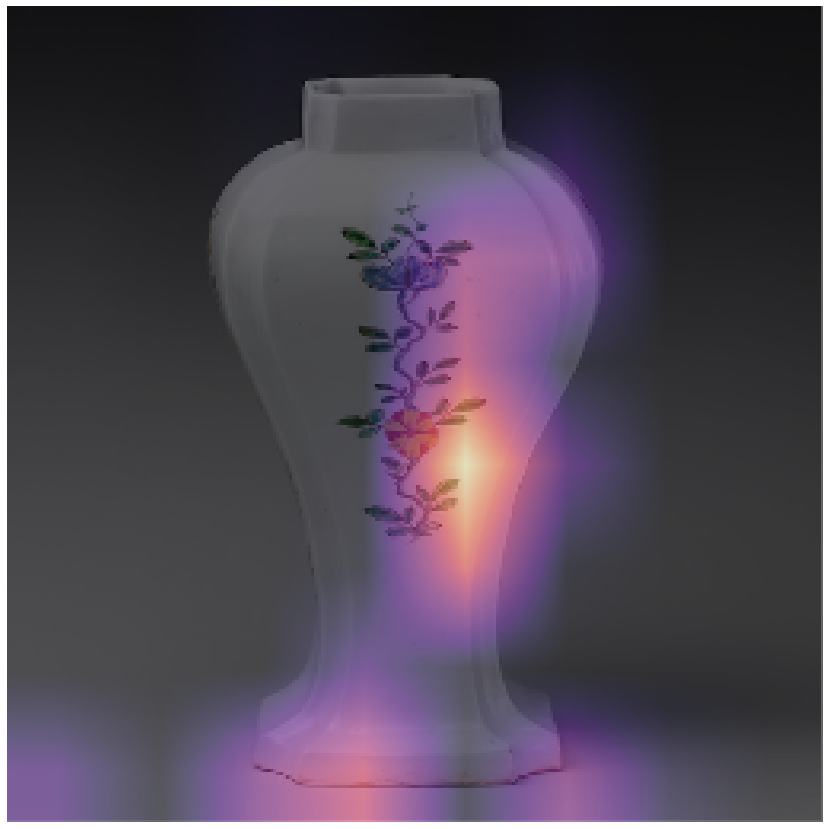

In [16]:
a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w = show_heatmap(interp, 500)